In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import cv2
import os
import pickle
from tqdm.notebook import tqdm
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D

In [2]:
pip install keras-facenet

     |████████████████████████████████| 2.3MB 20.7MB/s 
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-cp36-none-any.whl size=10387 sha256=9c77e0c2659b8f5a71c4d944aa6ae24a4a5419cf813192539e80ad342d1660c4
  Stored in directory: /root/.cache/pip/wheels/f6/53/9a/36c4b52fd22faf4f710d5047d874655b85a1b2cf77accfb9bd
Successfully built keras-facenet


In [3]:
from keras_facenet import FaceNet
facenet = FaceNet()

In [4]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
'''
maskdir = os.listdir('/content/gdrive/My Drive/final_dataset/face_mask')
noskdir = os.listdir('/content/gdrive/My Drive/final_dataset/face_nosk')
tucskdir = os.listdir('/content/gdrive/My Drive/final_dataset/face_tucsk')

images_list = []
label_list = []

for dir in os.listdir('/content/gdrive/My Drive/final_dataset'):
    for image in tqdm(os.listdir('/content/gdrive/My Drive/final_dataset/{}'.format(dir))):
        if dir == 'test_data':
            continue
        else:
            raw = cv2.imread('/content/gdrive/My Drive/final_dataset/{}/{}'.format(dir, image))
            resized = cv2.resize(raw, dsize=(224, 224))
            brg2rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
            preprocessed = preprocess_input(brg2rgb)
            images_list.append(preprocessed)

            label_list.append('yes' if dir == 'face_mask' else 'no')
'''

In [ ]:

'''
# 파일 저장하기
with open('/content/gdrive/My Drive/final_dataset/label_list.pkl', 'wb') as f:
    pickle.dump(label_list, f)
    f.close()
with open('/content/gdrive/My Drive/final_dataset/images_list.pkl', 'wb') as f:
    pickle.dump(images_list, f)
    f.close()
'''

In [5]:
with open('/content/gdrive/My Drive/final_dataset/images_list.pkl', 'rb') as f:
    images_list = pickle.load(f)
    f.close()
with open('/content/gdrive/My Drive/final_dataset/label_list.pkl', 'rb') as f:
    label_list = pickle.load(f)
    f.close()

In [6]:
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
label_list = np.array(label_list)    # 배열화
images_list = np.array(images_list)
print(label_list[:3])

label_list = LabelBinarizer().fit_transform(label_list)  
print(label_list[2000:2002])

label_list = to_categorical(label_list)
print(label_list[:3])

['no' 'no' 'no']
[[1]
 [1]]
[[1. 0.]
 [1. 0.]
 [1. 0.]]


In [7]:
type(images_list)

numpy.ndarray

In [8]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(images_list, label_list, stratify=label_list, shuffle=True)

In [50]:
# 테스트하는 함수

def img_test(model):  
  path = '/content/gdrive/My Drive/final_dataset/test_images/'
  path_list = os.listdir(path)
#   path_list.remove('face')
  for path_ in path_list:
    img = cv2.imread(path + path_)
    fn = FaceNet()
    plt.figure(figsize=(10, 6))
    plt.imshow(img[:, :, ::-1]) # BGR을 RGB로 바꿔줌
    faces = fn.crop(img)[1]
    plt.figure(figsize=(6, 3))
    for i, face in enumerate(faces):
        plt.subplot(1, len(faces), i+1)
        plt.imshow(face[:, :, ::-1])
    plt.figure(figsize=(6, 5))
    for i, face in enumerate(faces):
        face_input = cv2.resize(face, dsize=(224, 224))
        face_input = cv2.cvtColor(face_input, cv2.COLOR_BGR2RGB)
        face_input = preprocess_input(face_input)
        face_input = np.expand_dims(face_input, axis=0)
        mask, nomask = model.predict(face_input).squeeze()
        plt.subplot(1, len(faces), i+1)
        plt.imshow(face[:, :, ::-1])
        plt.title('%.2f%%' % (mask * 100))

In [10]:
import tensorflow as tf
vgg = tf.keras.models.load_model('/content/gdrive/My Drive/final_dataset/vgg16.h5')
ResNet = tf.keras.models.load_model('/content/gdrive/My Drive/final_dataset/ResNet.h5')
ImageNet = tf.keras.models.load_model('/content/gdrive/My Drive/final_dataset/imagenet.h5')


## 모바일넷

In [ ]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

9412608/9406464 [==============================] - 0s 0us/step


Epoch 1/20
95/95 [==============================] - 39s 415ms/step - loss: 0.2082 - accuracy: 0.9142 - val_loss: 0.1865 - val_accuracy: 0.9432
Epoch 2/20
95/95 [==============================] - 39s 406ms/step - loss: 0.0956 - accuracy: 0.9726 - val_loss: 0.1349 - val_accuracy: 0.9667
Epoch 3/20
95/95 [==============================] - 39s 409ms/step - loss: 0.0653 - accuracy: 0.9812 - val_loss: 0.1972 - val_accuracy: 0.9442
Epoch 4/20
95/95 [==============================] - 38s 405ms/step - loss: 0.0456 - accuracy: 0.9898 - val_loss: 0.1641 - val_accuracy: 0.9569
Epoch 5/20
95/95 [==============================] - 39s 408ms/step - loss: 0.0398 - accuracy: 0.9885 - val_loss: 0.1492 - val_accuracy: 0.9726
Epoch 6/20
95/95 [==============================] - 38s 404ms/step - loss: 0.0339 - accuracy: 0.9898 - val_loss: 0.1155 - val_accuracy: 0.9775
Epoch 7/20
95/95 [==============================] - 39s 406ms/step - loss: 0.0319 - accuracy: 0.9898 - val_loss: 0.1421 - val_accuracy: 0.9726

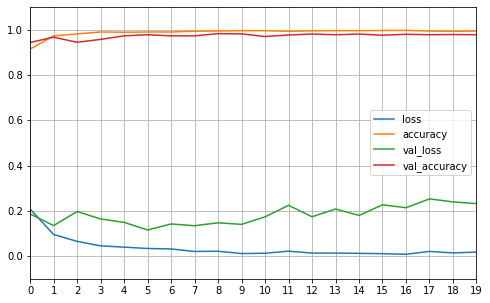

In [ ]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
H = model.fit(
        aug.flow(x_train, y_train, batch_size=BS),
        steps_per_epoch=len(x_train) // BS,
        validation_data=(x_test, y_test),
        validation_steps=len(x_test) // BS,
        epochs=EPOCHS)

pd.DataFrame(H.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(-0.1,1.1)
plt.xlim(0, 19)
plt.xticks([n for n in range(0, 20)])
plt.show()

In [ ]:
img_test(model)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# model.save('/content/gdrive/My Drive/final_dataset/imagenet.h5')

In [ ]:
# test_list = []
# for image in tqdm(os.listdir('/content/gdrive/My Drive/final_dataset/test_data/face/')):
#         raw = cv2.imread('/content/gdrive/My Drive/final_dataset/test_data/face/{}'.format(image))
#         resized = cv2.resize(raw, dsize=(224, 224))
#         brg2rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
#         preprocessed = preprocess_input(brg2rgb)
#         expanded = np.expand_dims(preprocessed, axis=0)
#         test_list.append(expanded)

## Seannet

In [ ]:
seannet = keras.models.Sequential([
    Conv2D(64,7,activation='relu',padding='same',input_shape=[224,224,3])
    ,MaxPooling2D(2)
    ,Conv2D(128,3,activation='relu',padding='same')
    ,Conv2D(128,3,activation='relu',padding='same')
    ,MaxPooling2D(2)
    ,Conv2D(256,3,activation='relu',padding='same')
    ,Conv2D(256,3,activation='relu',padding='same')
    ,MaxPooling2D(2)
    ,Flatten()
    ,Dense(128,activation='relu')
    ,Dropout(0.5)
    ,Dense(2,activation='softmax')
])

In [ ]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 64
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

seannet.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
H = seannet.fit(
        aug.flow(x_train, y_train, batch_size=BS),
        steps_per_epoch=len(x_train) // BS,
        validation_data=(x_test, y_test),
        validation_steps=len(x_test) // BS,
        epochs=EPOCHS)

Epoch 1/20
47/47 [==============================] - 42s 884ms/step - loss: 0.4536 - accuracy: 0.7816 - val_loss: 0.2901 - val_accuracy: 0.8904
Epoch 2/20
47/47 [==============================] - 36s 766ms/step - loss: 0.3189 - accuracy: 0.8766 - val_loss: 0.1864 - val_accuracy: 0.9413
Epoch 3/20
47/47 [==============================] - 36s 767ms/step - loss: 0.2807 - accuracy: 0.8980 - val_loss: 0.2021 - val_accuracy: 0.9315
Epoch 4/20
47/47 [==============================] - 36s 764ms/step - loss: 0.2788 - accuracy: 0.8970 - val_loss: 0.1612 - val_accuracy: 0.9442
Epoch 5/20
47/47 [==============================] - 36s 766ms/step - loss: 0.2454 - accuracy: 0.9136 - val_loss: 0.1324 - val_accuracy: 0.9569
Epoch 6/20
47/47 [==============================] - 36s 764ms/step - loss: 0.2311 - accuracy: 0.9176 - val_loss: 0.1287 - val_accuracy: 0.9609
Epoch 7/20
47/47 [==============================] - 36s 765ms/step - loss: 0.2031 - accuracy: 0.9303 - val_loss: 0.1187 - val_accuracy: 0.9648

In [ ]:
img_test(seannet)

Output hidden; open in https://colab.research.google.com to view.

## VGG16

In [ ]:
from tensorflow.keras.applications import VGG16 
from tensorflow.keras.applications import VGG19
baseModel = VGG16( include_top=False, weights='imagenet', input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = MaxPooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

vgg16 = Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

vgg16.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
H = vgg16.fit(
        aug.flow(x_train, y_train, batch_size=BS),
        steps_per_epoch=len(x_train) // BS,
        validation_data=(x_test, y_test),
        validation_steps=len(x_test) // BS,
        epochs=EPOCHS)

Epoch 1/20
95/95 [==============================] - 53s 562ms/step - loss: 0.2154 - accuracy: 0.9142 - val_loss: 0.1439 - val_accuracy: 0.9609
Epoch 2/20
95/95 [==============================] - 49s 518ms/step - loss: 0.0970 - accuracy: 0.9799 - val_loss: 0.0683 - val_accuracy: 0.9834
Epoch 3/20
95/95 [==============================] - 49s 519ms/step - loss: 0.0836 - accuracy: 0.9792 - val_loss: 0.0704 - val_accuracy: 0.9834
Epoch 4/20
95/95 [==============================] - 49s 517ms/step - loss: 0.0681 - accuracy: 0.9848 - val_loss: 0.0726 - val_accuracy: 0.9843
Epoch 5/20
95/95 [==============================] - 49s 520ms/step - loss: 0.0641 - accuracy: 0.9875 - val_loss: 0.0685 - val_accuracy: 0.9843
Epoch 6/20
95/95 [==============================] - 49s 520ms/step - loss: 0.0653 - accuracy: 0.9868 - val_loss: 0.0841 - val_accuracy: 0.9765
Epoch 7/20
95/95 [==============================] - 49s 519ms/step - loss: 0.0581 - accuracy: 0.9888 - val_loss: 0.1078 - val_accuracy: 0.9765

In [ ]:
img_test(vgg16)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# vgg16.save('/content/gdrive/My Drive/final_dataset/vgg16.h5')

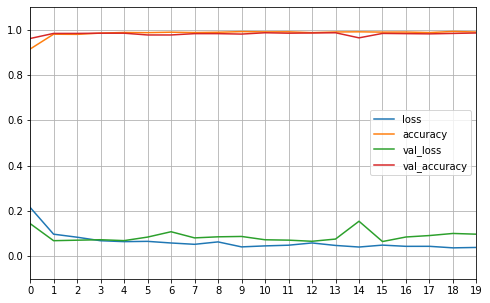

In [ ]:
pd.DataFrame(H.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(-0.1,1.1)
plt.xlim(0, 19)
plt.xticks([n for n in range(0, 20)])
plt.show()

## ResNet

In [ ]:
from tensorflow.keras.applications import ResNet50

baseModel = ResNet50( include_top=False, weights='imagenet', input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = MaxPooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

ResNet = Model(inputs=baseModel.input, outputs=headModel)

94773248/94765736 [==============================] - 0s 0us/step


Epoch 1/20
47/47 [==============================] - 46s 983ms/step - loss: 0.0241 - accuracy: 0.9943 - val_loss: 0.2879 - val_accuracy: 0.9775
Epoch 2/20
47/47 [==============================] - 45s 965ms/step - loss: 0.0193 - accuracy: 0.9937 - val_loss: 0.2637 - val_accuracy: 0.9804
Epoch 3/20
47/47 [==============================] - 46s 968ms/step - loss: 0.0291 - accuracy: 0.9940 - val_loss: 0.2938 - val_accuracy: 0.9755
Epoch 4/20
47/47 [==============================] - 45s 956ms/step - loss: 0.0387 - accuracy: 0.9907 - val_loss: 0.2980 - val_accuracy: 0.9755
Epoch 5/20
47/47 [==============================] - 45s 955ms/step - loss: 0.0347 - accuracy: 0.9910 - val_loss: 0.3008 - val_accuracy: 0.9677
Epoch 6/20
47/47 [==============================] - 45s 958ms/step - loss: 0.0240 - accuracy: 0.9923 - val_loss: 0.2445 - val_accuracy: 0.9795
Epoch 7/20
47/47 [==============================] - 45s 954ms/step - loss: 0.0223 - accuracy: 0.9950 - val_loss: 0.1958 - val_accuracy: 0.9795

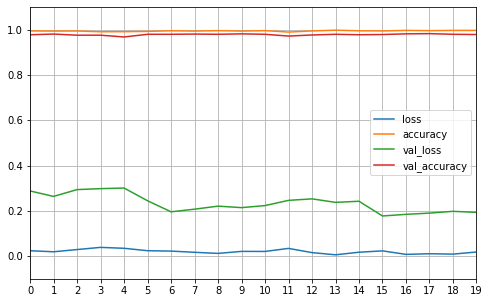

In [ ]:
# INIT_LR = 1e-4
# EPOCHS = 20
# BS = 64
# aug = ImageDataGenerator(
#     rotation_range=20,
#     zoom_range=0.15,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.15,
#     horizontal_flip=True,
#     fill_mode="nearest")

# opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

# ResNet.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# H = ResNet.fit(
#         aug.flow(x_train, y_train, batch_size=BS),
#         steps_per_epoch=len(x_train) // BS,
#         validation_data=(x_test, y_test),
#         validation_steps=len(x_test) // BS,
#         epochs=EPOCHS)

# pd.DataFrame(H.history).plot(figsize=(8,5))
# plt.grid(True)
# plt.gca().set_ylim(-0.1,1.1)
# plt.xlim(0, 19)
# plt.xticks([n for n in range(0, 20)])
# plt.show()

In [ ]:
img_test(ResNet)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# ResNet.save('/content/gdrive/My Drive/final_dataset/ResNet.h5')

In [ ]:
def img_test(model,path):  
  fn = FaceNet()
  img = cv2.imread(path)
  faces = fn.crop(img)
  face_output = img.copy()
  h, w, c = face_output.shape
  face_output = cv2.resize(face_output,dsize=(1080,int(h*1080/w)))
  for info, face in zip(faces[0],faces[1]):
    face_input = cv2.resize(face, dsize=(224, 224))
    face_input = cv2.cvtColor(face_input, cv2.COLOR_BGR2RGB)
    face_input = preprocess_input(face_input)
    face_input = np.expand_dims(face_input, axis=0)
    nomask, mask = model.predict(face_input).squeeze()
    if mask > nomask :
      color = (0,255,0)
      label = 'MASK {:.1f}%'.format(mask*100)
    else :
      color = (0,0,255)
      label = 'NO MASK {:.1f}%'.format(nomask*100)
    box = info['box']
    x1 = int(box[0] * 1080/w)
    y1 = int(box[1]* 1080/w)
    x2 = int(x1 + box[2]* 1080/w)
    y2 = int(y1 + box[3]* 1080/w)
    cv2.rectangle(face_output, pt1=(x1, y1), pt2=(x2, y2), thickness=2, color=color, lineType=cv2.LINE_AA)
    cv2.putText(face_output, text=label, org=(x1, y1 - 10), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1.5, color=color, thickness=3, lineType=cv2.LINE_AA)
  plt.figure(figsize = (12,12))
  plt.imshow(face_output[:, :, ::-1])

In [ ]:
os.lisdir

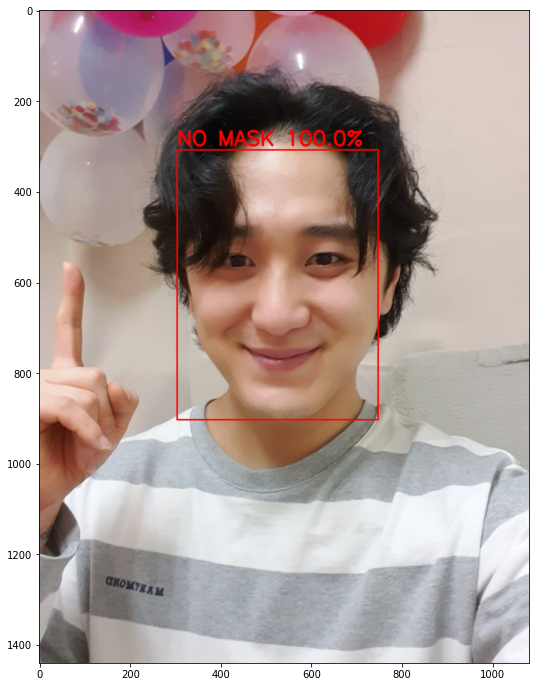

In [ ]:
img_test(ResNet, '/content/gdrive/My Drive/final_dataset/test_data/sean_no_jang.jpg')

In [ ]:
for name in ['a1', 'a2', 'a3', 'a4']:
    img_test(ResNet, '/content/gdrive/My Drive/final_dataset/test_images/'+name+'.jpg')

Output hidden; open in https://colab.research.google.com to view.

In [41]:
def conv2d(inputs, filters, stride_size, padding):
    output = tf.nn.conv2d(inputs, filters = filters, strides=[1, stride_size, stride_size, 1], padding=padding)
    return tf.nn.relu(output)

def maxpool(inputs, pool_size, stride_size):
    output = tf.nn.max_pool2d(inputs, ksize=[1, pool_size, pool_size, 1], Padding='SAME', strides=[1, stride_size, stride_size, 1])
    return output

def dense(inputs, w, dropout_rate):
    output = tf.nn.relu(tf.matmul(inputs, w))
    return tf.nn.dropout(output, rate=dropout_rate)

initializer = tf.initializers.he_normal()

In [44]:
def conv2d(inputs , filters, stride_size ):
    output = tf.nn.conv2d( inputs , filters , strides=[1, stride_size, stride_size , 1] , padding=padding ) 
    return tf.nn.relu(output) 

def maxpool(inputs , pool_size, stride_size ):
    return tf.nn.max_pool2d(inputs , ksize=[1, pool_size, pool_size, 1 ], padding='VALID' , strides=[ 1 , stride_size , stride_size , 1 ] )

def dense( inputs , weights ):
    x = tf.nn.relu( tf.matmul(inputs , weights ))
    return tf.nn.dropout( x , rate=dropout_rate )

def get_weight(shape, name):
    return tf.Variable(initializer(shape) , name=name , trainable=True , dtype=tf.float32)

In [45]:
shapes = [
    [ 3 , 3 , 3 , 16 ] , 
    [ 3 , 3 , 16 , 16 ] , 

    [ 3 , 3 , 16 , 32 ] , 
    [ 3 , 3 , 32 , 32 ] ,

    [ 3 , 3 , 32 , 64 ] , 
    [ 3 , 3 , 64 , 64 ] ,

    [ 3 , 3 , 64 , 128 ] , 
    [ 3 , 3 , 128 , 128 ] ,

    [ 3 , 3 , 128 , 256 ] , 
    [ 3 , 3 , 256 , 256 ] ,

    [ 3 , 3 , 256 , 512 ] , 
    [ 3 , 3 , 512 , 512 ] ,
    
    [ 8192 , 3600 ] , 
    [ 3600 , 2400 ] ,
    [ 2400 , 1600 ] , 
    [ 1600 , 800 ] ,
    [ 800 , 64 ] ,
    [ 64 , 2] ,
]

weights = []
for i in range( len( shapes ) ):
    weights.append( get_weight( shapes[ i ] , 'weight{}'.format( i ) ) )

In [24]:
x_train.shape

(3063, 224, 224, 3)

In [ ]:



seannet = keras.models.Sequential([
    Conv2D(64,7,activation='relu',padding='same',input_shape=[224,224,3])
    ,MaxPooling2D(2)
    ,Conv2D(128,3,activation='relu',padding='same')
    ,Conv2D(128,3,activation='relu',padding='same')
    ,MaxPooling2D(2)
    ,Conv2D(256,3,activation='relu',padding='same')
    ,Conv2D(256,3,activation='relu',padding='same')
    ,MaxPooling2D(2)
    ,Flatten()
    ,Dense(128,activation='relu')
    ,Dropout(0.5)
    ,Dense(2,activation='softmax')
])

In [51]:

img_test(ResNet)

Output hidden; open in https://colab.research.google.com to view.